<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/Hierarchical_Normal_Model_%26_Gibbs_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Overview:**
The dataset consists of annual death counts from five causes for the age group 25–34 over five years (2018–2022). These causes are:

Accidents, Homicide, Suicide, Heart Disease, Malignant Neoplasms
The goal is to model these death counts using three approaches:


*   Separate Gaussian model

*   Pooled Gaussian model
*   Hierarchical Gaussian model

**Why Gibbs Sampling:**
Gibbs sampling is a special case of the Metropolis-Hastings algorithm used for Bayesian inference, particularly when the full conditional distributions of the variables in a model can be easily sampled.

**a. Separate Model:** In a separate model, we treat each group or data source independently. When using Gibbs sampling here, each group's parameters are sampled independently from their respective conditional distributions.



*   **Specific to the model:**  Sample the parameters for each cause of death independently. Each death cause has its own parameters, which could lead to high variability in small samples.


**b. Pooled Model:** In a pooled model, the data from different groups are combined (or "pooled") and treated as if they came from a single distribution. Gibbs sampling in this model would sample the parameters from a single conditional distribution across all data. This reduces variance but may miss group-specific effects, assuming all groups are homogenous.

*   **Specific to the model:**  Pooled Model (Gibbs): Sample from a common parameter for all causes, assuming homogeneity.

**c. Hierarchical Model** (or Partially Pooled Model): In hierarchical models, group-level parameters (for individual groups) are treated as random variables drawn from a higher-level (hyperparameter) distribution. Gibbs sampling here involves sampling both the group-level parameters and the hyperparameters in a conditional step-by-step process. This approach balances between separate and pooled models, allowing group-specific variability while sharing information across groups.

*   **Specific to the model:** Sample group-specific parameters and hyperparameters, allowing for shared information while maintaining some independence between causes.




**General Setup:**

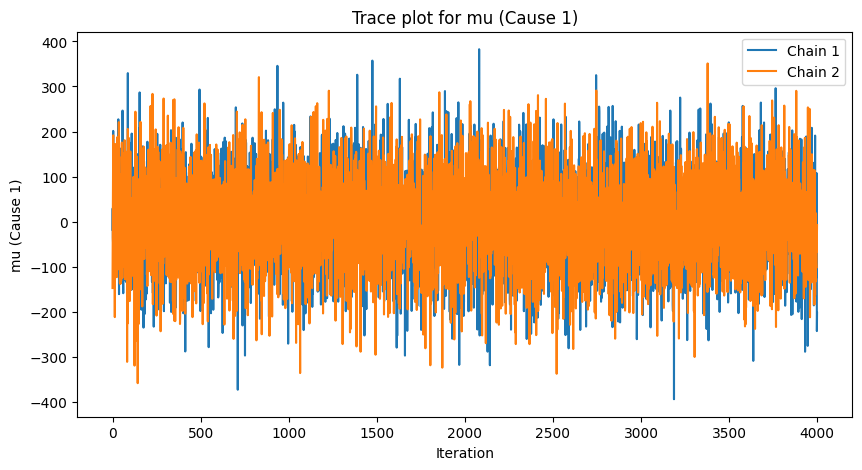

Posterior distribution of the mean of annual deaths for the 5 causes (from Gibbs sampling):
Posterior samples for the mean of annual deaths (Cause 1):
[-18.20103733  29.38614612 -35.64629044 -45.7810064  201.35455635
   1.15442475  42.18529655 -27.96053217  11.23283795 171.10771961]
Posterior samples for the mean of annual deaths (Cause 2):
[ 141.8197091  -167.11892391 -128.46100114  -39.21305658  185.65055071
 -110.66216095 -113.87141769 -127.94696423   49.74923858    4.94538228]
Posterior samples for the mean of annual deaths (Cause 3):
[ 156.46023974 -202.9453357    46.85670259  -15.85739396  -83.72866488
  -83.73047184   97.85427411 -121.9111066   255.82494795  -73.81075373]
Posterior samples for the mean of annual deaths (Cause 4):
[ 158.69068125 -173.57319356 -141.81943981  101.05766743   57.45610485
  -40.78717507 -174.12488485   85.30581635  -97.71694916    2.00902251]
Posterior samples for the mean of annual deaths (Cause 5):
[ -26.7425662    28.44308334  -82.1878351   -45.706

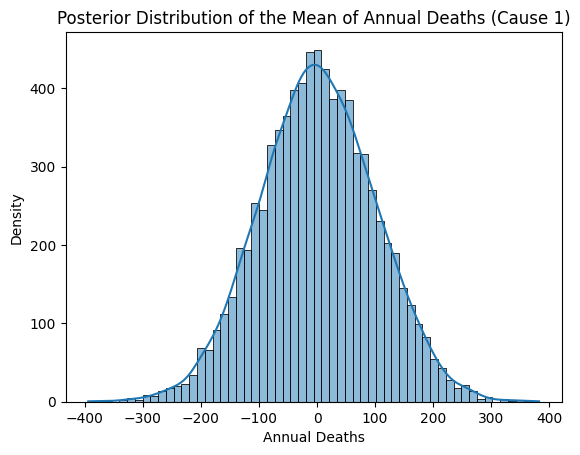

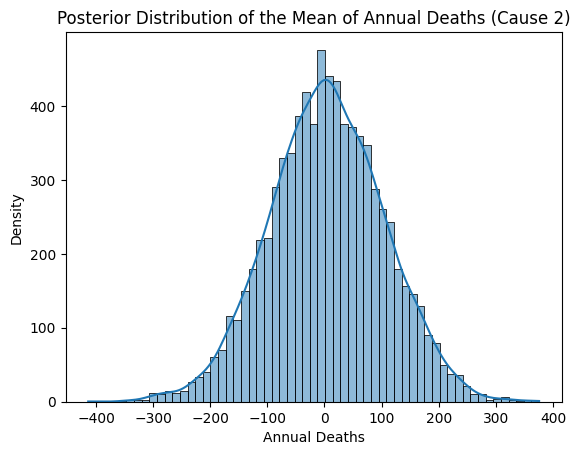

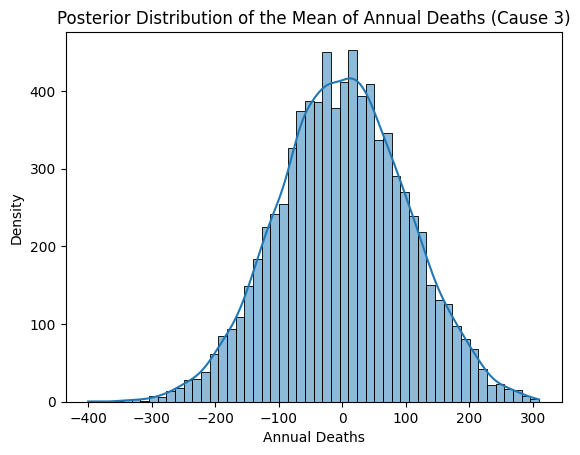

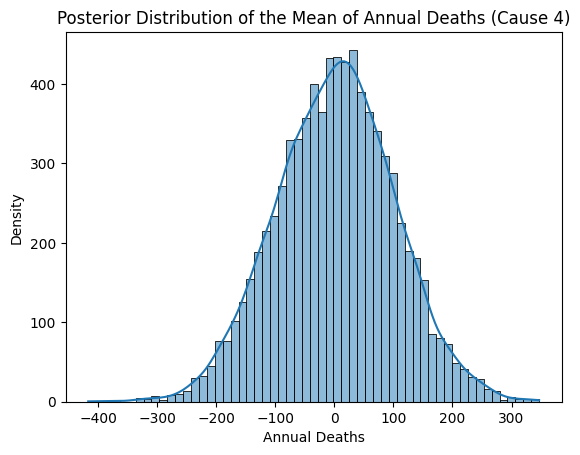

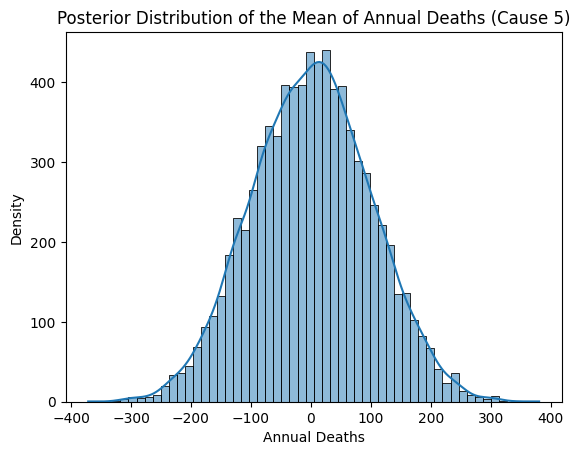

Predictive mean for hypothetical 6th cause: -17340.101899478545
The predictive distribution for a hypothetical (6th) cause of death: [ -3276.16700562 -27142.47518612 -10961.81697014  -8594.61453806
   2780.7211821 ]
The posterior of the mean of the annual deaths for the hypothetical cause: -31650.754448552685


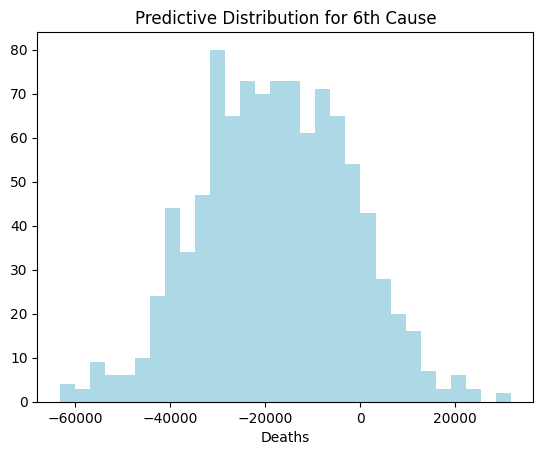

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gamma
import arviz as az  # Library for Bayesian analysis and MCMC diagnostics
# Set a random seed for reproducibility
np.random.seed(42)

# Death data for the five causes from 2018 to 2022
deaths = np.array([[33058, 34452, 31315, 24516, 24614],   # Accidents
                   [6712, 7571, 31315, 5341, 5234],       # Homicide
                   [8663, 8862, 8454, 8059, 8020],        # Suicide
                   [3789, 4155, 3984, 3495, 3561],        # Heart Disease
                   [3641, 3615, 3573, 3577, 3684]])       # Malignant Neoplasms

n_years, n_causes = deaths.shape

# Function to implement the separate Gaussian model using Gibbs sampling
def separate_gaussian(deaths, n_iter=5000, burn_in=1000):
    n_years, n_causes = deaths.shape

    # Prior hyperparameters for mu and sigma^2
    mu_prior_mean = 0
    mu_prior_variance = 100**2  # Non-informative prior
    alpha = 0.001  # Weakly informative prior for sigma^2
    beta = 0.001

    # Initialize parameters
    mu = np.mean(deaths, axis=0)  # Starting values for mu (mean for each cause)
    sigma2 = 1000  # Initial value for variance

    # Storage for MCMC samples
    mu_samples = np.zeros((n_iter, n_causes))
    sigma2_samples = np.zeros(n_iter)

    # Gibbs Sampling
    for iter in range(n_iter):
        # Update mu for each cause
        for c in range(n_causes):
            y_c = deaths[:, c]
            n = len(y_c)
            # Posterior mean and variance for mu
            mu_post_mean = (np.sum(y_c) / sigma2 + mu_prior_mean / mu_prior_variance) / \
                           (n / sigma2 + 1 / mu_prior_variance)
            mu_post_var = 1 / (n / sigma2 + 1 / mu_prior_variance)
            mu[c] = np.random.normal(mu_post_mean, np.sqrt(mu_post_var))

        # Update sigma^2
        residuals = deaths - mu
        ss = np.sum(residuals**2)
        sigma2_post_shape = alpha + 0.5 * n_years * n_causes
        sigma2_post_rate = beta + 0.5 * ss
        sigma2 = 1 / np.random.gamma(sigma2_post_shape, 1 / sigma2_post_rate)

        # Store samples
        mu_samples[iter, :] = mu
        sigma2_samples[iter] = sigma2

    # Remove burn-in period
    mu_samples = mu_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    return mu_samples, sigma2_samples

# Function to run multiple chains of the separate Gaussian model
def separate_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=2):
    chains = []

    for chain in range(n_chains):
        chains.append(separate_gaussian(deaths, n_iter, burn_in))

    return chains

# Running two chains
n_chains = 2
chains_results = separate_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=2)

# Extract both mu_samples and sigma2_samples for each chain
mu_samples_chain1 = chains_results[0][0]
mu_samples_chain2 = chains_results[1][0]

sigma2_samples_chain1 = chains_results[0][1]
sigma2_samples_chain2 = chains_results[1][1]

# Combine mu_samples and sigma2_samples for both chains
mu_samples_combined = np.concatenate([mu_samples_chain1, mu_samples_chain2], axis=0)
sigma2_samples_combined = np.concatenate([sigma2_samples_chain1, sigma2_samples_chain2], axis=0)


# Create trace plots for one of the causes (e.g., cause 1)
plt.figure(figsize=(10, 5))
plt.plot(mu_samples_chain1[:, 0], label="Chain 1")
plt.plot(mu_samples_chain2[:, 0], label="Chain 2")
plt.xlabel('Iteration')
plt.ylabel('mu (Cause 1)')
plt.title('Trace plot for mu (Cause 1)')
plt.legend()
plt.show()

# Posterior means of mu for each cause (from the first chain)
print("Posterior distribution of the mean of annual deaths for the 5 causes (from Gibbs sampling):")
for cause in range(n_causes):
    print(f"Posterior samples for the mean of annual deaths (Cause {cause + 1}):")
    print(mu_samples_combined[:, cause][:10])  # Print first 10 samples for each cause
# Plot posterior distribution for each cause using histograms
for cause in range(n_causes):
    sns.histplot(mu_samples_combined[:, cause], kde=True, label=f'Cause {cause + 1}')
    plt.title(f'Posterior Distribution of the Mean of Annual Deaths (Cause {cause + 1})')
    plt.xlabel('Annual Deaths')
    plt.ylabel('Density')
    plt.show()


# Predictive mean for a 6th hypothetical cause
mu_6_separate = np.random.normal(np.mean(posterior_means_separate), np.sqrt(np.mean(chains_results[0][1])))
print(f"Predictive mean for hypothetical 6th cause: {mu_6_separate}")

# Predictive distribution for the 6th cause (y_pred)
y_pred_separate = np.random.normal(mu_6_separate, np.sqrt(np.mean(chains_results[0][1])), 1000)

# Display the predictive mean for the 6th cause
print(f"The predictive distribution for a hypothetical (6th) cause of death: {y_pred_separate[:5]}")

mu_6_separate = np.random.normal(np.mean(posterior_means_separate), np.sqrt(np.mean(chains_results[0][1])))
print(f"The posterior of the mean of the annual deaths for the hypothetical cause: {mu_6_separate}")
# Visualize the predictive distribution for the 6th cause
plt.hist(y_pred_separate, bins=30, color="lightblue")
plt.title("Predictive Distribution for 6th Cause")
plt.xlabel("Deaths")
plt.show()

Gelman-Rubin diagnostic (R-hat):
<xarray.Dataset> Size: 88B
Dimensions:   (mu_dim_0: 5)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu        (mu_dim_0) float64 40B 0.9998 0.9998 1.0 1.001 0.9999
    sigma2    float64 8B 1.0
Effective Sample Size (ESS):
<xarray.Dataset> Size: 88B
Dimensions:   (mu_dim_0: 5)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu        (mu_dim_0) float64 40B 8.235e+03 7.969e+03 ... 7.62e+03 7.411e+03
    sigma2    float64 8B 7.786e+03


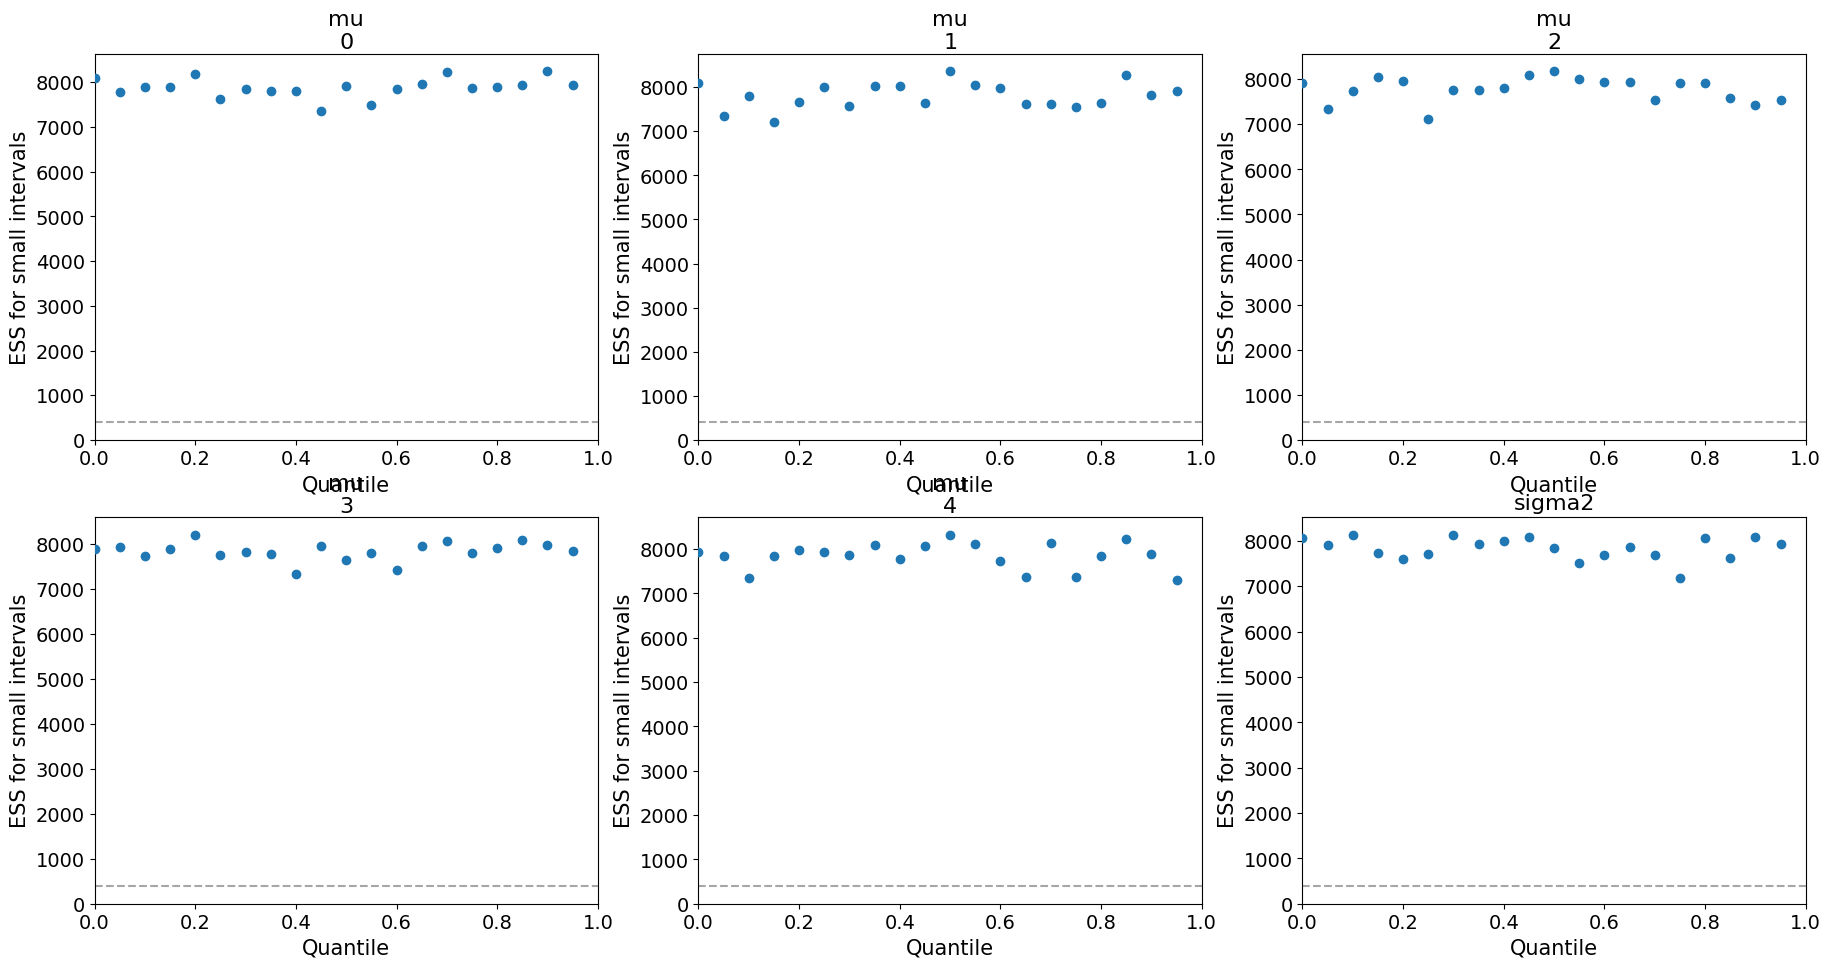

In [15]:
# ---- Convergence diagnostics using ArviZ ----
# Convert the results into a format that ArviZ can use
# Assuming we have two chains of mu and sigma2
mu_samples = [mu_samples_chain1, mu_samples_chain2]  # A list of chains
sigma2_samples = [sigma2_samples_chain1, sigma2_samples_chain2]  # A list of chains

# Create a dictionary for ArviZ, stacking the chains together along the first axis
az_data = az.from_dict(
    posterior={
        "mu": np.stack(mu_samples, axis=0),       # Stack chains for 'mu'
        "sigma2": np.stack(sigma2_samples, axis=0)  # Stack chains for 'sigma2'
    }
)


# Run Gelman-Rubin diagnostics (R-hat)
rhat = az.rhat(az_data)
print(f"Gelman-Rubin diagnostic (R-hat):\n{rhat}")

# If R-hat values are close to 1.0, it indicates convergence.

# Plot the effective sample size (ESS)
ess = az.ess(az_data)
print(f"Effective Sample Size (ESS):\n{ess}")

# Display ESS plot
az.plot_ess(az_data)
plt.show()


In [16]:
print(np.isnan(mu_samples_combined).any())
print(np.isnan(sigma2_samples_combined).any())


False
False
